**Data Analytics - PySpark**

**Food Classification**

**Installing the PySpark and required libraries**

1- Installing Java Development Kit version 8

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

2- Downloading and installing Apache Spark

In [ ]:
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar -xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark 
!pip install pyspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

In [ ]:
import findspark

In [ ]:
findspark.init()

In [ ]:
import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

3- Import the required libraries 

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import VectorAssembler
from pyspark import StorageLevel
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from typing import Optional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [ ]:
pd.set_option("display.max_rows", 30000)

4- Create Spark session

In [ ]:
spark = (SparkSession.builder.appName("ML_SPARK_RECIPES")
        .config("spark.driver.memory","8g")
        .getOrCreate()
        )

5- Import data

In [ ]:
food_data = spark.read.csv(
    "./epi_r.csv", inferSchema=True, header=True
)

In [ ]:
food_data.printSchema()

root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullable = true)


In [ ]:
print(f"The type of food_data is : {(str(type(food_data)))[8:-2]}")
print(f"Number of rows: {food_data.count()}")
print(f"Number of columns: {len(food_data.columns)}")

The type of food_data is : pyspark.sql.dataframe.DataFrame
Number of rows: 20057
Number of columns: 680


6- Cleaning the column names

In [ ]:
def clean_column_name(c_name):
    ref_chars = (("-", "_"), (" ", "_"), ("/", "_"), ("&", "and")) 
    n_name = c_name
    for i, j in ref_chars:
        n_name = n_name.replace(i,j)
    n_name = "". join([s_char for s_char in n_name 
                       if s_char.isalpha() or s_char.isdigit() or s_char=="_"])
    return n_name

In [ ]:
food_data = food_data.toDF(*list(map(clean_column_name,food_data.columns[0:680])))

7- Data exploring

In [ ]:
for x in food_data.columns:
    food_data.select(x).summary().show()

Streaming output truncated to the last 5000 lines.
| stddev| 0.02641461818687891|
|    min|                 0.0|
|    25%|                 0.0|
|    50%|                 0.0|
|    75%|                 0.0|
|    max|                 1.0|
+-------+--------------------+

+-------+--------------------+
|summary|              israel|
+-------+--------------------+
|  count|               20052|
|   mean|9.974067424695791E-5|
| stddev| 0.00998677625151559|
|    min|                 0.0|
|    25%|                 0.0|
|    50%|                 0.0|
|    75%|                 0.0|
|    max|                 1.0|
+-------+--------------------+

+-------+--------------------+
|summary|               italy|
+-------+--------------------+
|  count|               20052|
|   mean|2.992220227408737E-4|
| stddev|0.017295878338611285|
|    min|                 0.0|
|    25%|                 0.0|
|    50%|                 0.0|
|    75%|                 0.0|
|    max|                 1.0|
+-------+--------

8- Removing duplicated records

In [ ]:
food_data_v1 = food_data.distinct()
print(f"Number of Rows in Original Dataset: {food_data.count()}")
print(f"Number of Distinct Rows: {food_data_v1.count()}")

Number of Rows in Original Dataset: 20057
Number of Distinct Rows: 18256


9- Finding binary columns

In [ ]:
bin_cols = food_data_v1.agg(*[(F.size(F.collect_set(x)) == 2).alias(x) for x in food_data_v1.columns]).toPandas()
bin_cols

,title,rating,calories,protein,fat,sodium,cakeweek,wasteless,22_minute_meals,3_ingredient_recipes,30_days_of_groceries,advance_prep_required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony_bourdain,aperitif,appetizer,apple,apple_juice,apricot,arizona,artichoke,arugula,asian_pear,asparagus,aspen,atlanta,australia,avocado,back_to_school,backyard_bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,washington_dc,watercress,watermelon,wedding,weelicious,west_virginia,westwood,wheat_gluten_free,whiskey,white_wine,whole_wheat,wild_rice,windsor,wine,winter,wisconsin,wok,yellow_squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack_week,turkey
0,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [ ]:
food_data_v1.filter("cakeweek > 1.0 or wasteless > 1.0").\
select("title", "wasteless", "cakeweek").show(truncate=False)

+----------------------------------------------------------------+---------+--------+
|title                                                           |wasteless|cakeweek|
+----------------------------------------------------------------+---------+--------+
|"Beet Ravioli with Pine Nut ""Goat Cheese"" Rosemary-Cream Sauce|0.0      |880.0   |
|"""Pot Roast"" of Seitan                                        |0.0      |1188.0  |
|"Seafood ""Cataplana"" with Saffron                             |1439.0   |24.0    |
+----------------------------------------------------------------+---------+--------+



In [ ]:
food_data_v1 = food_data_v1.where(
(F.col("cakeweek").isin([0.0, 1.0]) | F.col("cakeweek").isNull() )
    &( F.col("wasteless").isin([0.0, 1.0]) | F.col("wasteless").isNull()  )
) 

In [ ]:
print(f"Number of rows: {food_data_v1.count()}")

Number of rows: 18253


In [ ]:
bin_cols = food_data_v1.agg(*[(F.size(F.collect_set(x)) == 2).alias(x) for x in food_data_v1.columns]).toPandas()
bin_cols

,title,rating,calories,protein,fat,sodium,cakeweek,wasteless,22_minute_meals,3_ingredient_recipes,30_days_of_groceries,advance_prep_required,alabama,alaska,alcoholic,almond,amaretto,anchovy,anise,anniversary,anthony_bourdain,aperitif,appetizer,apple,apple_juice,apricot,arizona,artichoke,arugula,asian_pear,asparagus,aspen,atlanta,australia,avocado,back_to_school,backyard_bbq,bacon,bake,banana,...,vegan,vegetable,vegetarian,venison,vermont,vermouth,vinegar,virginia,vodka,waffle,walnut,wasabi,washington,washington_dc,watercress,watermelon,wedding,weelicious,west_virginia,westwood,wheat_gluten_free,whiskey,white_wine,whole_wheat,wild_rice,windsor,wine,winter,wisconsin,wok,yellow_squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack_week,turkey
0,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


10- Grouping the features 

In [ ]:
CONTINUOUS_FEATURES = []
BINARY_FEATURES = []
CLASS_COLUMN = ["dessert"]
for x in bin_cols.columns[1:]:
    if bin_cols[x].values == False:
        CONTINUOUS_FEATURES.append(x)
    elif bin_cols[x].values == True and x not in CLASS_COLUMN:
        BINARY_FEATURES.append(x)

In [ ]:
CONTINUOUS_FEATURES

['rating', 'calories', 'protein', 'fat', 'sodium']

In [ ]:
BINARY_FEATURES

['cakeweek',
 'wasteless',
 '22_minute_meals',
 '3_ingredient_recipes',
 '30_days_of_groceries',
 'advance_prep_required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony_bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple_juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian_pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back_to_school',
 'backyard_bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille_day',
 'bean',
 'beef',
 'beef_rib',
 'beef_shank',
 'beef_tenderloin',
 'beer',
 'beet',
 'bell_pepper',
 'berry',
 'beverly_hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue_cheese',
 'blueberry',
 'boil',
 'bok_choy',
 'bon_appétit',
 'bon_apptit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisket',
 'broccoli',
 'broccoli_rabe',
 'broil',
 'brooklyn',
 'brown_ri

11- Dealing with missing values 

In [ ]:
food_data_v1.select([F.count(F.when(F.isnan(col) | F.col(col).isNull(), col)).alias(col) for col in food_data_v1.columns]).toPandas().unstack()

title                     0       0
rating                    0       5
calories                  0    3753
protein                   0    3785
fat                       0    3806
sodium                    0    3755
cakeweek                  0       6
wasteless                 0       6
22_minute_meals           0       5
3_ingredient_recipes      0       5
30_days_of_groceries      0       5
advance_prep_required     0       5
alabama                   0       5
alaska                    0       5
alcoholic                 0       5
almond                    0       5
amaretto                  0       5
anchovy                   0       5
anise                     0       5
anniversary               0       5
anthony_bourdain          0       5
aperitif                  0       5
appetizer                 0       5
apple                     0       5
apple_juice               0       5
apricot                   0       5
arizona                   0       5
artichoke                 0 

In [ ]:
subset_1 = [x for x in food_data.columns if x != 'title']
food_data_v1 = food_data_v1.dropna(how='all', subset=subset_1)

In [ ]:
print(f"Number of rows: {food_data_v1.count()}")

Number of rows: 18248


In [ ]:
food_data_v1 = food_data_v1.dropna(subset=CLASS_COLUMN)

In [ ]:
food_data_v1.filter("dessert is NULL").count()

0

In [ ]:
food_data_v1.fillna(0.0, subset=BINARY_FEATURES);

In [ ]:
print(food_data_v1.where(F.col(BINARY_FEATURES[2]).isNull()).count()) 

0


12- Cleaning continuous features

In [ ]:
@F.udf(T.BooleanType())
def num_verify(arg: Optional[str]) -> bool:
    if not arg:
        return True
    try:
        _ = float(arg)
    except ValueError:
        return False
    return True

In [ ]:
food_data_v1.where(~num_verify(F.col("rating"))).select(
    *CONTINUOUS_FEATURES
).show()

+---------+------------+-------+----+------+
|   rating|    calories|protein| fat|sodium|
+---------+------------+-------+----+------+
| Cucumber| and Lemon "|   3.75|null|  null|
+---------+------------+-------+----+------+



In [ ]:
for x in ['rating','calories']:
    food_data_v1 = (food_data_v1.where(num_verify(F.col(x)))) \
    .withColumn(x,F.col(x).cast(T.DoubleType()))

In [ ]:
print(f"Number of rows: {food_data_v1.count()}")

Number of rows: 18247


In [ ]:
food_data_v1.filter("calories is NULL").count()

3748

In [ ]:
summary_cont_featrs = food_data_v1.select("calories", "protein", "fat", "sodium").summary(
    "mean", "min", "1%","99%", "max"
).toPandas()

In [ ]:
mean_values = summary_cont_featrs[summary_cont_featrs['summary']=='mean'].iloc[:,1:].transpose().to_dict()[0]

In [ ]:
mean_values

{'calories': '6623.372784329954',
 'fat': '363.46639440714335',
 'protein': '92.24061657565494',
 'sodium': '6574.946130500759'}

In [ ]:
food_data_v1 = food_data_v1.fillna(mean_values)

In [ ]:
food_data_v1.filter("calories is NULL").count()

0

13- Removing the categorical features that are not good enough to be considered as reliable predictors

In [ ]:
num_of_rows = food_data_v1.count()
rare_binary_cols = [col \
                    for col,v in food_data_v1.select(*[F.sum(F.col(x)).alias(x) \
                                                     for x in BINARY_FEATURES]).head().asDict().items() \
                    if v < 10 or v > (num_of_rows-10)]


In [ ]:
rare_binary_cols

['cakeweek',
 'wasteless',
 '30_days_of_groceries',
 'alabama',
 'alaska',
 'anthony_bourdain',
 'apple_juice',
 'arizona',
 'aspen',
 'atlanta',
 'australia',
 'beverly_hills',
 'biscuit',
 'boston',
 'bran',
 'brooklyn',
 'brownie',
 'buffalo',
 'bulgaria',
 'burrito',
 'cambridge',
 'camping',
 'canada',
 'caviar',
 'chicago',
 'chili',
 'cobbler_crumble',
 'columbus',
 'cook_like_a_diner',
 'cookbook_critic',
 'costa_mesa',
 'cranberry_sauce',
 'crêpe',
 'crme_de_cacao',
 'cuba',
 'cupcake',
 'custard',
 'dallas',
 'denver',
 'digestif',
 'dominican_republic',
 'dorie_greenspan',
 'eau_de_vie',
 'egg_nog',
 'egypt',
 'emeril_lagasse',
 'england',
 'entertaining',
 'epi__ushg',
 'epi_loves_the_microwave',
 'flat_bread',
 'frankenrecipe',
 'freezer_food',
 'friendsgiving',
 'frittata',
 'fritter',
 'germany',
 'grains',
 'grand_marnier',
 'granola',
 'grappa',
 'guam',
 'haiti',
 'hamburger',
 'hawaii',
 'healdsburg',
 'hollywood',
 'house_cocktail',
 'houston',
 'hummus',
 'iced_cof

In [ ]:
len(rare_binary_cols)

172

In [ ]:
print(f"Number of columns: {len(food_data_v1.columns)}")

Number of columns: 680


In [ ]:
for x in rare_binary_cols:
    food_data_v1 = food_data_v1.drop(x)

In [ ]:
print(f"Number of columns: {len(food_data_v1.columns)}")

Number of columns: 508


In [ ]:
BINARY_FEATURES = list(set(BINARY_FEATURES)-set(rare_binary_cols))

13- Feature scaling 

In [ ]:
continuous_features_assembler = VectorAssembler(
    inputCols=CONTINUOUS_FEATURES, outputCol="continuous_features_assembler"
)

In [ ]:
food_data_v2 = continuous_features_assembler.transform(food_data_v1)

In [ ]:
food_data_v2.select('continuous_features_assembler').show(10,False)

+--------------------------------------------------------------------------------+
|continuous_features_assembler                                                   |
+--------------------------------------------------------------------------------+
|[3.75,6623.372784329954,92.24061657565494,363.46639440714335,6574.946130500759] |
|[3.75,6623.372784329954,92.24061657565494,363.46639440714335,6574.946130500759] |
|[5.0,29.0,4.0,1.0,57.0]                                                         |
|[4.375,217.0,23.0,11.0,777.0]                                                   |
|[3.75,257.0,4.0,1.0,49.0]                                                       |
|[3.75,301.0,24.0,18.0,114.0]                                                    |
|[3.125,6623.372784329954,92.24061657565494,363.46639440714335,6574.946130500759]|
|[4.375,892.0,47.0,60.0,455.0]                                                   |
|[4.375,307.0,1.0,0.0,18.0]                                                      |
|[4.

In [ ]:
scaler_min_max = MinMaxScaler(
    inputCol="continuous_features_assembler", outputCol="scaled_continuous_values",
)

In [ ]:
food_data_v3 = scaler_min_max.fit(food_data_v2).transform(
    food_data_v2
)

In [ ]:
food_data_v3.select("scaled_continuous_values").show(3,False)

+--------------------------------------------------------------------------------------------+
|scaled_continuous_values                                                                    |
+--------------------------------------------------------------------------------------------+
|[0.75,2.199636289813967E-4,3.900418902175363E-4,2.1097875587480308E-4,2.3757615165759987E-4]|
|[0.75,2.199636289813967E-4,3.900418902175363E-4,2.1097875587480308E-4,2.3757615165759987E-4]|
|[1.0,9.630962121824498E-7,1.6914105941502564E-5,5.804628959409971E-7,2.059612409851307E-6]  |
+--------------------------------------------------------------------------------------------+
only showing top 3 rows



14- Preparing final dataset for modelling

In [ ]:
final_data_asmblr = VectorAssembler(
    inputCols= BINARY_FEATURES + ["scaled_continuous_values"],
    outputCol="indpnt_features"
)

In [ ]:
food_data_v4 = final_data_asmblr.transform(food_data_v3)

In [ ]:
food_data_v4.select('title','dessert','indpnt_features').show(3,truncate=30)

+------------------------------+-------+------------------------------+
|                         title|dessert|               indpnt_features|
+------------------------------+-------+------------------------------+
|     Peanut Butter Berry–Wich |    0.0|(506,[10,51,63,116,117,127,...|
|Grilled Swordfish and Green...|    0.0|(506,[109,154,169,200,224,2...|
|                   Veal Stock |    0.0|(506,[31,192,270,316,355,39...|
+------------------------------+-------+------------------------------+
only showing top 3 rows



15- Machine learning model - Logistic Regression Classifier

In [ ]:
lr_classifier = LogisticRegression(
    featuresCol="indpnt_features", labelCol='dessert', predictionCol="y_pred"
)

In [ ]:
train, test = food_data_v4.randomSplit([0.7,0.3])

In [ ]:
train.persist(StorageLevel.MEMORY_ONLY);

In [ ]:
lr_model = lr_classifier.fit(train)

In [ ]:
predicted_values = lr_model.transform(test)

16- Model evaluation

In [ ]:
predicted_and_actual = predicted_values.select('y_pred','dessert').rdd

In [ ]:
model_metrics = MulticlassMetrics(predicted_and_actual)

In [ ]:
model_confusion_matrix = pd.DataFrame(
    model_metrics.confusionMatrix().toArray(),
    index=["dessert=0", "dessert=1"],
    columns=["predicted=0", "predicted=1"],
)

In [ ]:
model_confusion_matrix

,predicted=0,predicted=1
dessert=0,4467.0,93.0
dessert=1,91.0,882.0


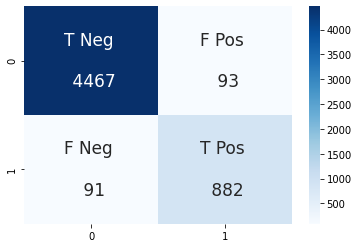

In [ ]:
labels =  ['T Neg','F Pos','F Neg','T Pos'] 

confusion_matrix_values = ["{0:0.0f}".format(x) for x in\
                           model_metrics.confusionMatrix().toArray().flatten() ]
labels_and_values = [f"{v1} \n \n {v2}" for v1,v2 in zip(labels,confusion_matrix_values)]

labels_and_values = np.asarray(labels_and_values).reshape(2,2)

sns.heatmap(model_metrics.confusionMatrix().toArray(),\
            annot=labels_and_values, fmt='', cmap='Blues',annot_kws={"fontsize":17});

In [ ]:
print(f"Model accuracy: {model_metrics.accuracy}")
print(f"Model precision: {model_metrics.precision(1.0)}")
print(f"Model recall: {model_metrics.recall(1.0)}")
print(f"Model f1-score: {model_metrics.fMeasure(1.0)}")

Model accuracy: 0.9667449846376288
Model precision: 0.9046153846153846
Model recall: 0.9064748201438849
Model f1-score: 0.9055441478439424


In [ ]:
ROC_evaluator = BinaryClassificationEvaluator(
    labelCol="dessert", rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

In [ ]:
model_roc = ROC_evaluator.evaluate(predicted_values)
print(f"Area under ROC of the model = {model_roc} ")

Area under ROC of the model = 0.9925254908854872 


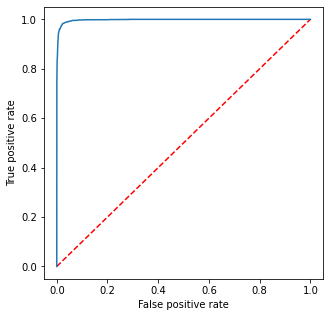

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], "r--")
plt.plot(
    lr_model.summary.roc.select("FPR").collect(),
    lr_model.summary.roc.select("TPR").collect(),
)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [ ]:
predicted_values.select('dessert','y_pred').show()

+-------+------+
|dessert|y_pred|
+-------+------+
|    0.0|   0.0|
|    0.0|   0.0|
|    1.0|   1.0|
|    0.0|   0.0|
|    0.0|   0.0|
|    0.0|   0.0|
|    0.0|   0.0|
|    1.0|   1.0|
|    0.0|   0.0|
|    0.0|   0.0|
|    0.0|   0.0|
|    1.0|   1.0|
|    0.0|   0.0|
|    0.0|   0.0|
|    0.0|   0.0|
|    1.0|   1.0|
|    0.0|   1.0|
|    1.0|   1.0|
|    0.0|   0.0|
|    0.0|   0.0|
+-------+------+
only showing top 20 rows

